In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import codecs
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data_RNN/data_RNN/cities_train/train/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []
category_val_lines = {}
all_val_categories = [] 


# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data_RNN/data_RNN/cities_train/train/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
for filename in findFiles('data_RNN/data_RNN/cities_val/val/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_val_categories.append(category)
    lines = readLines(filename)
    category_val_lines[category] = lines

n_categories = len(all_categories)
n_val_categories = len(all_val_categories)

['data_RNN/data_RNN/cities_train/train\\af.txt', 'data_RNN/data_RNN/cities_train/train\\cn.txt', 'data_RNN/data_RNN/cities_train/train\\de.txt', 'data_RNN/data_RNN/cities_train/train\\fi.txt', 'data_RNN/data_RNN/cities_train/train\\fr.txt', 'data_RNN/data_RNN/cities_train/train\\in.txt', 'data_RNN/data_RNN/cities_train/train\\ir.txt', 'data_RNN/data_RNN/cities_train/train\\pk.txt', 'data_RNN/data_RNN/cities_train/train\\za.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [5]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


We will also want a quick way to get a training example (a name and its
language):




In [6]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomValExample():
    category = randomChoice(all_val_categories)
    line = randomChoice(category_val_lines[category])
    category_tensor = torch.tensor([all_val_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = in / line = karasing
category = fr / line = frenchman cove
category = cn / line = qianjinbu
category = in / line = new burlington
category = in / line = shekeiniba
category = pk / line = bahram khan balaidi
category = fi / line = chak two hundred five
category = pk / line = mondrani khalol
category = cn / line = dalongkeng
category = fr / line = zaafran


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [7]:
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor,rnn, learning_rate):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item(), rnn

def loss_evaluate(category_tensor, line_tensor,rnn):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()

    return loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [8]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




In [9]:


# Just return an output given a line
def evaluate(line_tensor, rnn):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output



Running on User Input
---------------------




In [10]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


5000 5% (0m 24s) 2.1842 kurees / pk ✗ (za)
10000 10% (0m 46s) 1.7718 xiakoucun / fr ✗ (cn)
15000 15% (1m 8s) 1.7968 marques de abrantes / af ✗ (de)
20000 20% (1m 30s) 1.9317 wuchun / pk ✗ (cn)
25000 25% (1m 56s) 1.8680 rizadey / fr ✗ (de)
30000 30% (2m 19s) 2.1607 las virginias / za ✗ (in)
35000 35% (2m 53s) 1.7400 ban sa khanom chin / de ✗ (in)
40000 40% (3m 24s) 0.5904 wildercroft / cn ✗ (de)
45000 45% (3m 50s) 1.8854 wafangtien / in ✗ (cn)
50000 50% (4m 16s) nan spina / af ✓
55000 55% (4m 44s) nan saintgeorgesdemontaigu / af ✗ (in)
60000 60% (5m 11s) nan oulad filala / af ✗ (fi)
65000 65% (5m 34s) nan dhala / af ✗ (pk)
70000 70% (6m 2s) nan jashar / af ✗ (pk)
75000 75% (6m 30s) nan berghall / af ✗ (fi)
80000 80% (6m 58s) nan ragiti / af ✗ (ir)
85000 85% (7m 21s) nan mecutira / af ✗ (ir)
90000 90% (7m 47s) nan esnouveaux / af ✗ (fr)
95000 95% (8m 12s) nan himoinen / af ✗ (fi)
100000 100% (8m 36s) nan center point gardens / af ✗ (de)
0.121


C:\Users\liam9\AppData\Local\Temp\ipykernel_38560\171602739.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_val_categories, rotation=90)
C:\Users\liam9\AppData\Local\Temp\ipykernel_38560\171602739.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_val_categories)


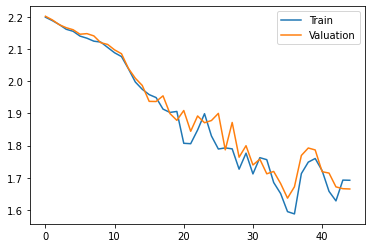

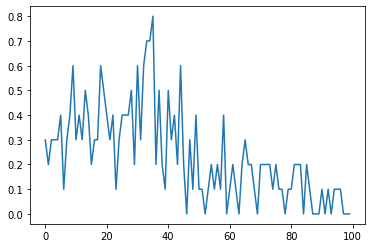

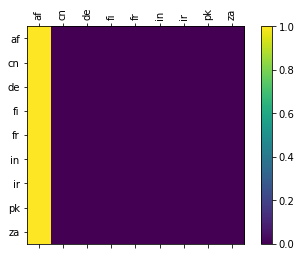

5000 5% (0m 24s) 1.9252 karpinvaara / cn ✗ (fi)
10000 10% (0m 47s) 1.2933 gadebusch / af ✗ (de)
15000 15% (1m 13s) 1.7337 sandar / af ✗ (pk)
20000 20% (1m 39s) 1.1429 kazarinovka / in ✗ (za)
25000 25% (2m 8s) 2.1574 bakhs / za ✗ (ir)
30000 30% (2m 35s) 3.0920 chayashan / in ✗ (cn)
35000 35% (3m 4s) nan mikros prinos / af ✗ (in)
40000 40% (3m 31s) nan bhachran / af ✗ (pk)
45000 45% (3m 57s) nan nazar garhi / af ✗ (pk)
50000 50% (4m 27s) nan kinong dzong / af ✗ (cn)
55000 55% (4m 55s) nan torpparinmaki / af ✗ (fi)
60000 60% (5m 27s) nan bourgdubost / af ✗ (fr)
65000 65% (5m 52s) nan padenganploso / af ✗ (de)
70000 70% (6m 19s) nan azamazu / af ✗ (za)
75000 75% (6m 44s) nan slapkina / af ✗ (pk)
80000 80% (7m 5s) nan les grands chezeaux / af ✗ (fr)
85000 85% (7m 26s) nan janaza / af ✗ (za)
90000 90% (7m 47s) nan lamumiao / af ✗ (cn)
95000 95% (8m 8s) nan bon tang / af ✗ (ir)
100000 100% (8m 29s) nan pasishakhimardan / af ✓
0.1185


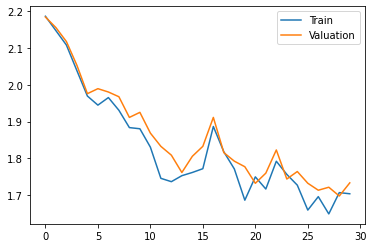

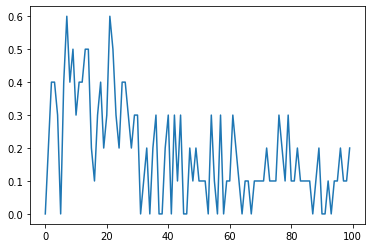

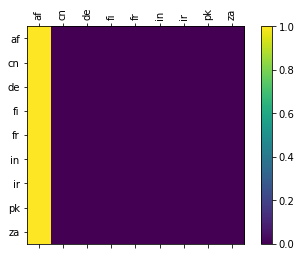

5000 5% (0m 21s) 2.1908 chakki muzaffar shah / cn ✗ (pk)
10000 10% (0m 42s) 2.0914 chichezai / fr ✗ (za)
15000 15% (1m 3s) 2.2722 satin / cn ✗ (pk)
20000 20% (1m 25s) 1.8843 shah afrae bala / pk ✗ (af)
25000 25% (1m 47s) 2.2852 dermqijas / fr ✗ (de)
30000 30% (2m 7s) 2.0030 shahzaid / cn ✗ (za)
35000 35% (2m 29s) 1.9216 zonza / fr ✓
40000 40% (2m 50s) 1.7309 mafsiagobaba / de ✗ (za)
45000 45% (3m 11s) 1.2473 asagimicingirt / pk ✗ (ir)
50000 50% (3m 32s) 1.1617 medina quemade / de ✓
55000 55% (3m 54s) 1.0953 ratial / pk ✓
60000 60% (4m 15s) 1.1237 jafferabad / fi ✗ (pk)
65000 65% (4m 36s) 0.8390 police post / de ✗ (za)
70000 70% (4m 57s) 1.0690 justis ghari / fr ✗ (pk)
75000 75% (5m 18s) 0.9546 auterrive / za ✗ (fr)
80000 80% (5m 39s) 4.7432 layliainen / za ✗ (fi)
85000 85% (6m 0s) 1.4207 sikhtopa / af ✓
90000 90% (6m 21s) 1.3061 basti kalian / in ✗ (pk)
95000 95% (6m 43s) 0.7922 ferruzzano / in ✗ (za)
100000 100% (7m 4s) 0.4088 lam'ya / za ✗ (af)
0.4731


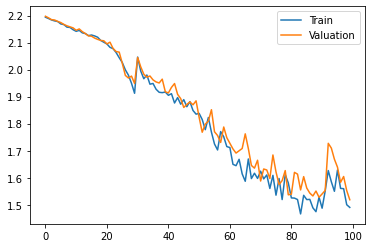

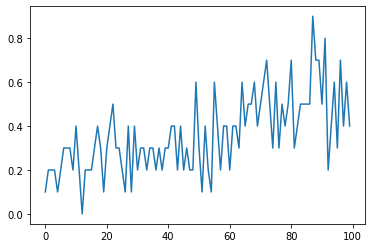

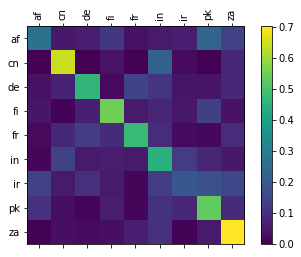

5000 5% (0m 15s) 2.1489 dafo / af ✗ (cn)
10000 10% (0m 31s) 2.1141 mahana / pk ✗ (in)
15000 15% (0m 47s) 2.5818 nordenlund / in ✗ (fi)
20000 20% (1m 3s) 2.6849 lutshino / de ✗ (in)
25000 25% (1m 19s) 3.2210 zabanangoro / in ✗ (za)
30000 30% (1m 35s) 1.1882 wanquetin / cn ✗ (fr)
35000 35% (1m 50s) 0.9672 koskiaho / de ✗ (fi)
40000 40% (2m 6s) 0.5882 lorenzreuth / pk ✗ (de)
45000 45% (2m 22s) 2.1748 zangoue / za ✓
50000 50% (2m 38s) 0.4033 lepanges / fi ✗ (fr)
55000 55% (2m 54s) 1.7915 jiuquan shi / fi ✗ (cn)
60000 60% (3m 9s) 1.5877 vieiras bravos / in ✗ (ir)
65000 65% (3m 25s) 2.0746 dianbianzi / fr ✗ (cn)
70000 70% (3m 41s) 0.4192 tongyuanli / fr ✗ (cn)
75000 75% (3m 59s) 1.2981 ragiti / de ✗ (ir)
80000 80% (4m 21s) 1.8102 karrapu / pk ✗ (ir)
85000 85% (4m 38s) 3.0263 al muzayrib / de ✗ (za)
90000 90% (4m 56s) 1.6305 chandar gol / af ✗ (pk)
95000 95% (5m 13s) 0.6655 meijie / in ✗ (cn)
100000 100% (5m 31s) 1.9398 qala viala / in ✗ (pk)
0.4997


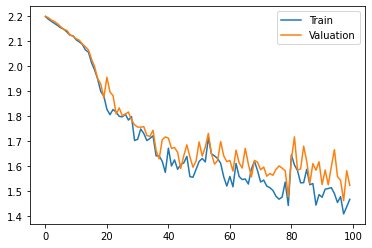

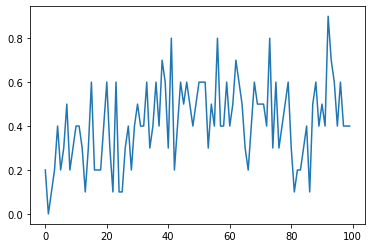

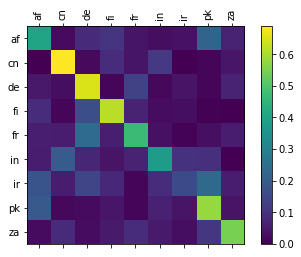

5000 5% (0m 26s) 2.0540 finsterbergen / fr ✗ (fi)
10000 10% (0m 53s) 1.9748 bourgdubost / cn ✗ (fr)
15000 15% (1m 20s) 1.5684 saraguaina / af ✗ (in)
20000 20% (1m 49s) 1.9051 nangangshang / za ✗ (cn)
25000 25% (2m 26s) 2.4572 cazenaveserreetallens / fi ✗ (fr)
30000 30% (3m 4s) 1.0570 wiranden / fi ✗ (de)
35000 35% (3m 41s) 1.0201 muntele fillii / de ✗ (fi)
40000 40% (4m 18s) 1.7304 vachhu pat / fi ✗ (pk)
45000 45% (4m 56s) 0.9569 lakthi / af ✗ (pk)
50000 50% (5m 38s) 3.3170 uafino / de ✗ (af)
55000 55% (6m 15s) 2.4264 samengtzu / pk ✗ (cn)
60000 60% (6m 53s) 1.4568 baninathpur / de ✗ (in)
65000 65% (7m 30s) 0.2317 torpparinmaki / fi ✓
70000 70% (8m 7s) 2.3909 la fauga / fi ✗ (fr)
75000 75% (8m 43s) 2.3024 dashai / in ✗ (pk)
80000 80% (9m 20s) 1.0229 thannhof / cn ✗ (de)
85000 85% (9m 56s) 1.5993 tamruta / za ✗ (pk)
90000 90% (10m 33s) 1.0193 nowe qal'ah / de ✗ (af)
95000 95% (11m 9s) 0.5377 paltah / cn ✗ (af)
100000 100% (11m 47s) 0.4833 palsa / in ✗ (fi)
0.4367


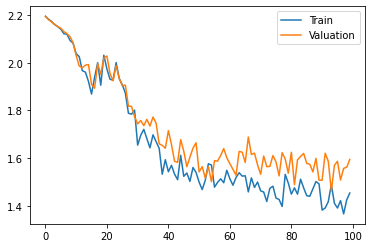

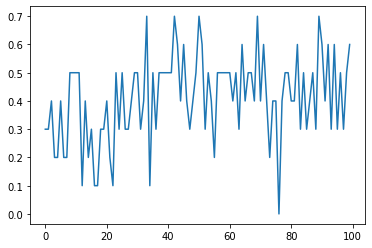

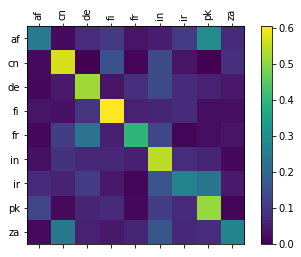

In [11]:
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def full_model(n_hidden, learning_rate):
    rnn = RNN(n_letters, n_hidden, n_categories)

    input = letterToTensor('A')
    hidden = torch.zeros(1, n_hidden)

    output, next_hidden = rnn(input, hidden)

    n_iters = 100000
    print_every = 5000
    plot_every = 1000



    # Keep track of losses for plotting
    current_loss = 0
    current_val_loss = 0
    current_accuracy = 0
    all_losses = []
    all_val_losses = []
    all_accuracy = []

    start = time.time()
    
    

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss, rnn = train(category_tensor, line_tensor, rnn, learning_rate)
        current_loss += loss
        category, line, category_tensor, line_tensor = randomValExample()
        val_loss = loss_evaluate(category_tensor, line_tensor, rnn)
        current_val_loss += val_loss
        

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            if guess == category:
                trainCorrect = trainCorrect+1
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
            trainTotal = trainTotal+1

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            trainCorrect = 0
            trainTotal = 0
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            all_val_losses.append(current_val_loss / plot_every)
            current_val_loss = 0
            for i in range(10):
                category, line, category_tensor, line_tensor = randomValExample()
                output = evaluate(line_tensor, rnn)
                guess, guess_i = categoryFromOutput(output)
                if guess == category:
                    trainCorrect =trainCorrect +1
                category_i = all_val_categories.index(category)
                trainTotal = trainTotal + 1
            all_accuracy.append(trainCorrect / trainTotal)
                
            
    plt.figure()
    plt.plot(all_losses)
    plt.plot(all_val_losses)
    plt.legend(['Train', 'Valuation'])
    
    plt.figure()
    plt.plot(all_accuracy)


    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_val_categories, n_val_categories)
    n_confusion = 10000

    # Go through a bunch of examples and record which are correctly guessed
    numCorrect = 0
    numTotal = 0
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomValExample()
        output = evaluate(line_tensor, rnn)
        guess, guess_i = categoryFromOutput(output)
        if guess == category:
            numCorrect = numCorrect+1
        category_i = all_val_categories.index(category)
        confusion[category_i][guess_i] += 1
        numTotal = numTotal + 1

    # Normalize by dividing every row by its sum
    for i in range(n_val_categories):
        confusion[i] = confusion[i] / confusion[i].sum()


    accuracy = numCorrect/numTotal
    print(accuracy)

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_val_categories, rotation=90)
    ax.set_yticklabels([''] + all_val_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

full_model(128,0.002)
full_model(128,0.008)
full_model(128,0.001)
full_model(64,0.002)
full_model(256,0.002)